In [48]:
from sklearnex import patch_sklearn
patch_sklearn()

import re
import sys
import os

sys.path.append(os.path.abspath(os.path.join("..")))

import numpy as np
from tqdm import tqdm
import pandas as pd
import optuna
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from joblib import Parallel, delayed

from utils import calc_metrics

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 41825352
num_columns = ['inflation', 'rate', 'usd', 'usd_cur_change_relative']

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [63]:
X = pd.read_csv('../data/x.csv', index_col='date')
y = pd.read_csv('../data/y.csv', index_col='date').iloc[:, 0]

metrics = pd.read_csv('metrics.csv', index_col=0)

scaler = StandardScaler()
scaler.fit(X[num_columns])
X[num_columns] = scaler.transform(X[num_columns])

### Tf-idf и линейная модель

Протестируем TF-IDF на текстах релизов.

In [50]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return text

vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
)

vectorizer.fit(X.release)

tf_idf = vectorizer.transform(X.release)
Xpreproc = X.release.apply(preprocessor)

In [10]:
auc = Parallel(n_jobs=-1)(delayed(calc_metrics)(
    tf_idf, y,
    LogisticRegression, 
    name='tf-idf l1 only release', 
    plot=False, 
    solver='liblinear', 
    penalty='l1', 
    C=c.item(),
    random_state=RANDOM_STATE
) for c in np.linspace(0.001, 100, 100))

roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - LogisticRegression(C=15.152363636363637, penalty='l1', random_state=41825352,
                   solver='liblinear')
ROC-AUC = 0.7896057032212638


              precision    recall  f1-score   support

        -1.0       0.69      0.78      0.73        23
         0.0       0.52      0.54      0.53        26
         1.0       0.67      0.53      0.59        19

    accuracy                           0.62        68
   macro avg       0.63      0.62      0.62        68
weighted avg       0.62      0.62      0.61        68



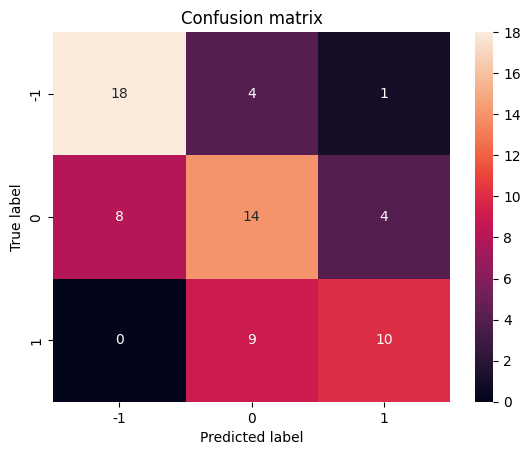

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.617647,0.623226,0.633465,0.617174,0.764882,0.770478
bow elasticnet,0.602941,0.606085,0.617424,0.599630,0.779381,0.783093
bow release title,0.573529,0.579365,0.591162,0.572317,0.782876,0.786569
bow release all num,0.573529,0.579365,0.591162,0.572317,0.776894,0.781362
bow svc only release,0.632353,0.641077,0.650132,0.634718,0.784936,0.790207
tf_idf l1 only release,0.617647,0.617077,0.625831,0.615795,0.784421,0.789606


In [13]:
metric, model = calc_metrics(
    tf_idf, y, 
    LogisticRegression, 
    name='tf_idf l1 only release', 
    **best_model.get_params()
    )
metrics = pd.concat([metrics, metric], axis=0)
metrics

Как и для мешка слов, используем логистическую регрессию с L1-регуляризацией для отбора признаков и подберем оптимальные параметры:

In [57]:
def objective(trial, texts):
    # параметры для перебора
    params = {
        'C': trial.suggest_float('C', 0.01, 500),
        'C2': trial.suggest_float('C2', 0.01, 500),
        'l1_ratio': trial.suggest_float('l1_ratio', 0.001, 1),
        'max_df': trial.suggest_float('max_df', 0.1, 1),
        'min_df': trial.suggest_int('min_df', 1, 10),
    }

    # векторизуем текст
    vectorizer = TfidfVectorizer(max_df=params['max_df'], min_df=params['min_df'])
    tf_idf = vectorizer.fit_transform(texts).toarray()

    # определяем модель для отбора признаков
    estimator = LogisticRegression(
        penalty="l1", solver="liblinear", C=params["C"], max_iter=1000, random_state=RANDOM_STATE
    )

    # определяем pipeline
    pipeline = Pipeline([
        ("selector", SelectFromModel(estimator)),
        (
            "model",
            LogisticRegression(C=params["C2"], l1_ratio=params["l1_ratio"], solver='saga',
                                     penalty='elasticnet', max_iter=10000,
                                     random_state=RANDOM_STATE),
        ),
    ])

    # считаем метрики на кросс валидации
    try:
        metric, _ = calc_metrics(tf_idf, y, pipeline, name=" ", plot=False, calc_jobs=-1)
    except ValueError or IndexError:
        return -np.inf

    return metric

# устанавливаем уровень логирования optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, Xpreproc), n_trials=100, show_progress_bar=True)

Best trial: 94. Best value: 0.813516: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


In [59]:
study.best_params

{'C': 314.4514299161778,
 'C2': 497.6742497312242,
 'l1_ratio': 0.9972764146433436,
 'max_df': 0.9776706639870457,
 'min_df': 8}

              precision    recall  f1-score   support

        -1.0       0.79      0.83      0.81        23
         0.0       0.62      0.69      0.65        26
         1.0       0.80      0.63      0.71        19

    accuracy                           0.72        68
   macro avg       0.74      0.72      0.72        68
weighted avg       0.73      0.72      0.72        68



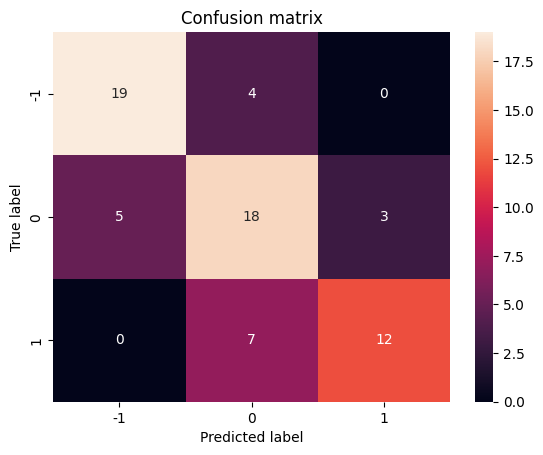

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.617647,0.623226,0.633465,0.617174,0.764882,0.770478
bow elasticnet,0.602941,0.606085,0.617424,0.599630,0.779381,0.783093
bow release title,0.573529,0.579365,0.591162,0.572317,0.782876,0.786569
bow release all num,0.573529,0.579365,0.591162,0.572317,0.776894,0.781362
bow svc only release,0.632353,0.641077,0.650132,0.634718,0.784936,0.790207
tf_idf l1 only release,0.617647,0.617077,0.625831,0.615795,0.784421,0.789606
tf_idf only release best word,0.720588,0.722979,0.737452,0.716658,0.808578,0.813516


In [64]:
vectorizer = TfidfVectorizer(preprocessor=preprocessor,
                             min_df=study.best_params["min_df"],
                             max_df=study.best_params["max_df"])

tf_idf = vectorizer.fit_transform(X.release).toarray()

estimator = LogisticRegression(
    penalty="l1", solver="liblinear", C=study.best_params["C"], max_iter=1000, random_state=RANDOM_STATE
)

pipeline = Pipeline([
    ("selector", SelectFromModel(estimator)),
    (
        "model",
        LogisticRegression(C=study.best_params["C2"], l1_ratio=study.best_params["l1_ratio"], solver='saga',
                                    penalty='elasticnet', max_iter=10000,
                                    random_state=RANDOM_STATE),
    ),
])

metric, model = calc_metrics(
    tf_idf, y, 
    pipeline, 
    name='tf_idf only release best word'
)

metrics = pd.concat([metrics, metric], axis=0)
metrics

Качество еще немного подросло. Как и в случае с мешком слов попробуем обучить tf-idf на названиях и добавим эти переменые в матрицу объект-признак.

In [65]:
text_titles = X.title.apply(preprocessor) + ' ' + Xpreproc

study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, text_titles), n_trials=100, show_progress_bar=True)

Best trial: 71. Best value: 0.816596: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


              precision    recall  f1-score   support

        -1.0       0.78      0.78      0.78        23
         0.0       0.60      0.69      0.64        26
         1.0       0.80      0.63      0.71        19

    accuracy                           0.71        68
   macro avg       0.73      0.70      0.71        68
weighted avg       0.72      0.71      0.71        68



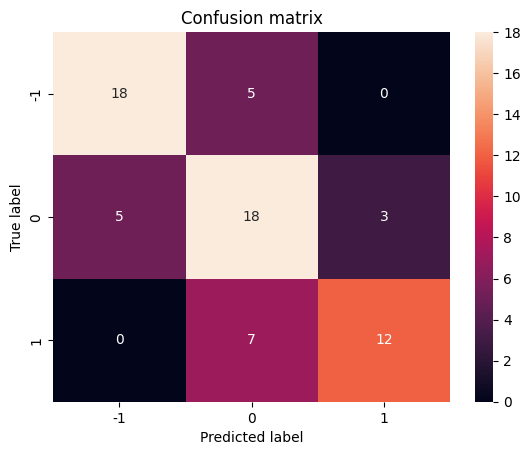

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.617647,0.623226,0.633465,0.617174,0.764882,0.770478
bow elasticnet,0.602941,0.606085,0.617424,0.599630,0.779381,0.783093
bow release title,0.573529,0.579365,0.591162,0.572317,0.782876,0.786569
bow release all num,0.573529,0.579365,0.591162,0.572317,0.776894,0.781362
bow svc only release,0.632353,0.641077,0.650132,0.634718,0.784936,0.790207
tf_idf l1 only release,0.617647,0.617077,0.625831,0.615795,0.784421,0.789606
tf_idf only release best word,0.720588,0.722979,0.737452,0.716658,0.808578,0.813516
tf_idf title release,0.705882,0.710449,0.727536,0.702165,0.811914,0.816596


In [66]:
vectorizer = TfidfVectorizer(preprocessor=preprocessor,
                             min_df=study.best_params["min_df"],
                             max_df=study.best_params["max_df"])

tf_idf_title = vectorizer.fit_transform(X.title + ' ' + X.release).toarray()

estimator = LogisticRegression(
    penalty="l1", solver="liblinear", C=study.best_params["C"], max_iter=1000, random_state=RANDOM_STATE
)

pipeline = Pipeline([
    ("selector", SelectFromModel(estimator)),
    (
        "model",
        LogisticRegression(C=study.best_params["C2"], l1_ratio=study.best_params["l1_ratio"], solver='saga',
                                    penalty='elasticnet', max_iter=10000,
                                    random_state=RANDOM_STATE),
    ),
])

metric, model = calc_metrics(
    tf_idf_title, y, 
    pipeline, 
    name='tf_idf title release', 
)

metrics = pd.concat([metrics, metric], axis=0)
metrics

Как и в случае мешка слов, при добавлении названия качество модели падает по метрике accuracy. Попробуем добавить количественные переменные.

In [67]:
def objective(trial):
    # параметры для перебора
    params = {
        'C': trial.suggest_float('C', 0.01, 500),
        'C2': trial.suggest_float('C2', 0.01, 500),
        'l1_ratio': trial.suggest_float('l1_ratio', 0.001, 1),
        'max_df': trial.suggest_float('max_df', 0.1, 1),
        'min_df': trial.suggest_int('min_df', 1, 10),
    }

    # векторизуем текст
    vectorizer = TfidfVectorizer(max_df=params['max_df'], min_df=params['min_df'])
    tf_idf = vectorizer.fit_transform(Xpreproc).toarray()

    # добавляем числовые признаки
    tf_idf_num = np.concatenate((tf_idf, X[num_columns].values), axis=1)

    # определяем модель для отбора признаков
    estimator = LogisticRegression(
        penalty="l1", solver="liblinear", C=params["C"], max_iter=1000, random_state=RANDOM_STATE
    )

    # определяем pipeline
    pipeline = Pipeline([
        ("selector", SelectFromModel(estimator)),
        (
            "model",
            LogisticRegression(C=params["C2"], l1_ratio=params["l1_ratio"], solver='saga',
                                     penalty='elasticnet', max_iter=10000,
                                     random_state=RANDOM_STATE),
        ),
    ])

    # считаем метрики на кросс валидации
    try:
        metric, _ = calc_metrics(tf_idf_num, y, pipeline, name=" ", plot=False, calc_jobs=-1)
    except ValueError or IndexError:
        return -np.inf

    return metric

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

Best trial: 68. Best value: 0.776844: 100%|██████████| 100/100 [01:41<00:00,  1.02s/it]


              precision    recall  f1-score   support

        -1.0       0.70      0.61      0.65        23
         0.0       0.53      0.73      0.61        26
         1.0       0.83      0.53      0.65        19

    accuracy                           0.63        68
   macro avg       0.69      0.62      0.64        68
weighted avg       0.67      0.63      0.63        68



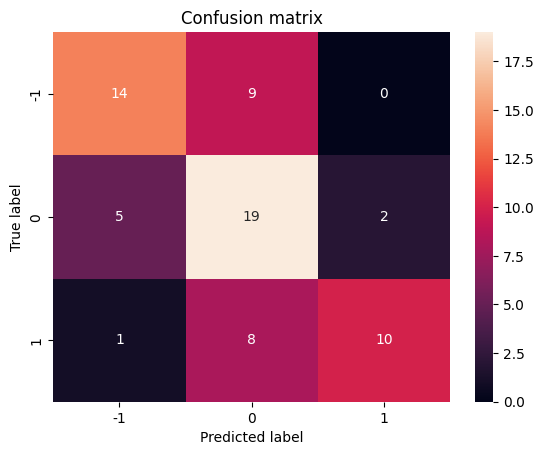

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.617647,0.623226,0.633465,0.617174,0.764882,0.770478
bow elasticnet,0.602941,0.606085,0.617424,0.599630,0.779381,0.783093
bow release title,0.573529,0.579365,0.591162,0.572317,0.782876,0.786569
bow release all num,0.573529,0.579365,0.591162,0.572317,0.776894,0.781362
bow svc only release,0.632353,0.641077,0.650132,0.634718,0.784936,0.790207
tf_idf l1 only release,0.617647,0.617077,0.625831,0.615795,0.784421,0.789606
tf_idf only release best word,0.720588,0.722979,0.737452,0.716658,0.808578,0.813516
tf_idf title release,0.705882,0.710449,0.727536,0.702165,0.811914,0.816596
tf_idf numerical release,0.632353,0.636409,0.687037,0.621927,0.774436,0.776844


In [71]:
vectorizer = TfidfVectorizer(preprocessor=preprocessor,
                             min_df=study.best_params["min_df"],
                             max_df=study.best_params["max_df"])

tf_idf = vectorizer.fit_transform(X.release).toarray()
tf_idf_num = np.concatenate((tf_idf, X[num_columns].values), axis=1)

estimator = LogisticRegression(
    penalty="l1", solver="liblinear", C=study.best_params["C"], max_iter=1000, random_state=RANDOM_STATE
)

pipeline = Pipeline([
    ("selector", SelectFromModel(estimator)),
    (
        "model",
        LogisticRegression(C=study.best_params["C2"], l1_ratio=study.best_params["l1_ratio"], solver='saga',
                                    penalty='elasticnet', max_iter=10000,
                                    random_state=RANDOM_STATE),
    ),
])

metric, model = calc_metrics(
    tf_idf_num, y,
    pipeline,
    name='tf_idf numerical release', 
)

metrics = pd.concat([metrics, metric], axis=0)
metrics

Добавление цифр из наших данных только ухудшило нашу модель. Попробуем обучить SVC, на tf-idf матрице лучших слов.

In [72]:
def objective(trial, texts):
    # параметры для перебора
    params = {
        'C': trial.suggest_float('C', 0.01, 500),
        'C2': trial.suggest_float('C2', 0.01, 500),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'max_df': trial.suggest_float('max_df', 0.1, 1),
        'min_df': trial.suggest_int('min_df', 1, 10),
    }

    # векторизуем текст
    vectorizer = TfidfVectorizer(max_df=params['max_df'], min_df=params['min_df'])
    tf_idf = vectorizer.fit_transform(texts).toarray()

    # определяем модель для отбора признаков
    estimator = LogisticRegression(
        penalty="l1", solver="liblinear", C=params["C"], max_iter=1000, random_state=RANDOM_STATE
    )

    # определяем pipeline
    pipeline = Pipeline([
        ("selector", SelectFromModel(estimator)),
        (
            "model",
            SVC(C=params["C2"], kernel=params['kernel'], probability=True, random_state=RANDOM_STATE),
        ),
    ])

    # считаем метрики на кросс валидации
    try:
        metric, _ = calc_metrics(tf_idf, y, pipeline, name=" ", plot=False, calc_jobs=-1)
    except ValueError or IndexError:
        return -np.inf

    return metric

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, Xpreproc), n_trials=100, show_progress_bar=True)

Best trial: 20. Best value: 0.844115: 100%|██████████| 100/100 [00:24<00:00,  4.07it/s]


In [73]:
study.best_params

{'C': 179.60420717202715,
 'C2': 443.27906207757445,
 'kernel': 'rbf',
 'max_df': 0.999255624327396,
 'min_df': 10}

              precision    recall  f1-score   support

        -1.0       0.76      0.83      0.79        23
         0.0       0.59      0.62      0.60        26
         1.0       0.75      0.63      0.69        19

    accuracy                           0.69        68
   macro avg       0.70      0.69      0.69        68
weighted avg       0.69      0.69      0.69        68



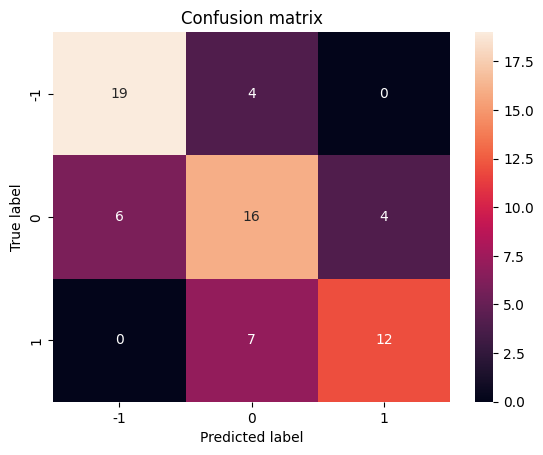

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.617647,0.623226,0.633465,0.617174,0.764882,0.770478
bow elasticnet,0.602941,0.606085,0.617424,0.599630,0.779381,0.783093
bow release title,0.573529,0.579365,0.591162,0.572317,0.782876,0.786569
bow release all num,0.573529,0.579365,0.591162,0.572317,0.776894,0.781362
bow svc only release,0.632353,0.641077,0.650132,0.634718,0.784936,0.790207
tf_idf l1 only release,0.617647,0.617077,0.625831,0.615795,0.784421,0.789606
tf_idf only release best word,0.720588,0.722979,0.737452,0.716658,0.808578,0.813516
tf_idf title release,0.705882,0.710449,0.727536,0.702165,0.811914,0.816596
tf_idf numerical release,0.632353,0.636409,0.687037,0.621927,0.774436,0.776844


In [74]:
vectorizer = TfidfVectorizer(preprocessor=preprocessor,
                             min_df=study.best_params["min_df"],
                             max_df=study.best_params["max_df"])

tf_idf = vectorizer.fit_transform(X.release).toarray()

estimator = LogisticRegression(
    penalty="l1", solver="liblinear", C=study.best_params["C"], max_iter=1000, random_state=RANDOM_STATE
)

pipeline = Pipeline([
    ("selector", SelectFromModel(estimator)),
    (
        "model",
        SVC(C=study.best_params["C2"], kernel=study.best_params['kernel'],
            probability=True, random_state=RANDOM_STATE),
    ),
])

metric, _ = calc_metrics(
    tf_idf, y, 
    pipeline, 
    name='tf-idf svc only release', 
)

metrics = pd.concat([metrics, metric])
metrics

Мы еще немного улучшились.

In [75]:
metrics.to_csv('metrics.csv')